In [1]:
%pip install -r requirements.txt

You should consider upgrading via the '/home/taffarel55/Repositórios/tcc/5. Modelo tflite com venv/env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib
from tensorflow.keras import layers

2023-08-27 02:04:16.429042: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-27 02:04:16.457766: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-27 02:04:16.619730: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-27 02:04:16.620606: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-27 02:04:18.148512: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [3]:
# Print versions
!python --version
print('Numpy ' + np.__version__)
print('TensorFlow ' + tf.__version__)
print('Matplotlib ' + matplotlib.__version__)

Python 3.9.0
Numpy 1.24.3
TensorFlow 2.12.0
Matplotlib 3.7.1


In [4]:
# Settings
nsamples = 1000     # Number of samples to use as a dataset
val_ratio = 0.2     # Percentage of samples that should be held for validation set
test_ratio = 0.2    # Percentage of samples that should be held for test set
tflite_model_name = 'sine_model'  # Will be given .tflite suffix
c_model_name = 'sine_model'       # Will be given .h suffix

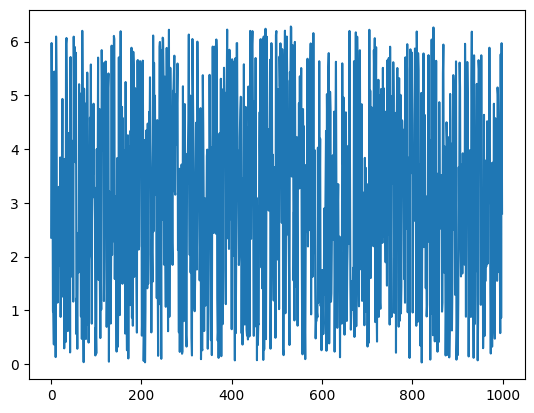

In [5]:
# Generate some random samples
np.random.seed(42)
x_values = np.random.uniform(low=0, high=(2 * math.pi), size=nsamples)
plt.plot(x_values)

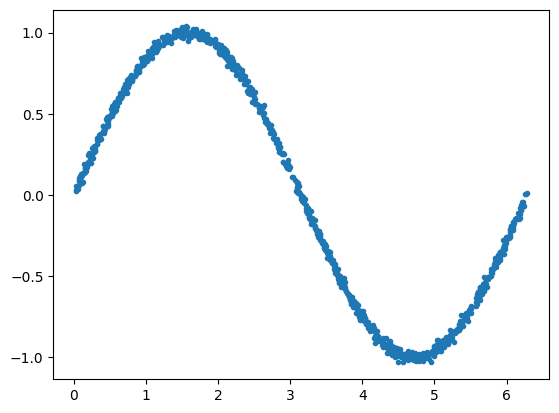

In [6]:
# Create a noisy sinewave with these values
y_values = np.sin(x_values) + (0.02 * np.random.randn(x_values.shape[0]))
plt.plot(x_values, y_values, '.')
     

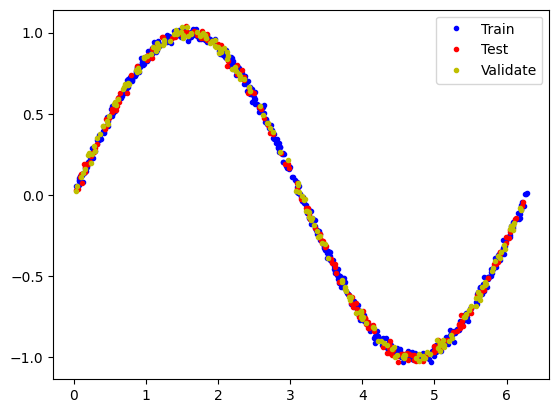

In [7]:
# Plit the dataset into training, validation, and test sets
val_split = int(val_ratio * nsamples)
test_split = int(val_split + (test_ratio * nsamples))
x_val, x_test, x_train = np.split(x_values, [val_split, test_split])
y_val, y_test, y_train = np.split(y_values, [val_split, test_split])

# Check that our splits add up correctly
assert(x_train.size + x_val.size + x_test.size) == nsamples

# Plot the data in each partition in different colors:
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.plot(x_val, y_val, 'y.', label="Validate")
plt.legend()
plt.show()

In [62]:
# Create a model
model = tf.keras.Sequential()
model.add(layers.Dense(20, activation='softmax', input_shape=(1,)))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(1))

In [63]:
# View model
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 20)                40        
                                                                 
 dense_19 (Dense)            (None, 20)                420       
                                                                 
 dense_20 (Dense)            (None, 1)                 21        
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


In [64]:
# Add optimizer, loss function, and metrics to model and compile it
model.compile(optimizer='rmsprop', loss='mae', metrics=['mae'])

In [65]:
# Train model
history = model.fit(x_train,
                    y_train,
                    epochs=500,
                    batch_size=100,
                    validation_data=(x_val, y_val))

Epoch 1/500


6/6 [==============================] - 1s 38ms/step - loss: 0.6183 - mae: 0.6183 - val_loss: 0.6323 - val_mae: 0.6323
Epoch 2/500
6/6 [==============================] - 0s 6ms/step - loss: 0.5986 - mae: 0.5986 - val_loss: 0.6189 - val_mae: 0.6189
Epoch 3/500
6/6 [==============================] - 0s 6ms/step - loss: 0.5868 - mae: 0.5868 - val_loss: 0.6083 - val_mae: 0.6083
Epoch 4/500
6/6 [==============================] - 0s 6ms/step - loss: 0.5776 - mae: 0.5776 - val_loss: 0.5990 - val_mae: 0.5990
Epoch 5/500
6/6 [==============================] - 0s 6ms/step - loss: 0.5687 - mae: 0.5687 - val_loss: 0.5898 - val_mae: 0.5898
Epoch 6/500
6/6 [==============================] - 0s 6ms/step - loss: 0.5602 - mae: 0.5602 - val_loss: 0.5807 - val_mae: 0.5807
Epoch 7/500
6/6 [==============================] - 0s 6ms/step - loss: 0.5515 - mae: 0.5515 - val_loss: 0.5711 - val_mae: 0.5711
Epoch 8/500
6/6 [==============================] - 0s 6ms/step - loss: 0.5426 - mae: 0.5426 - val_loss: 0.56

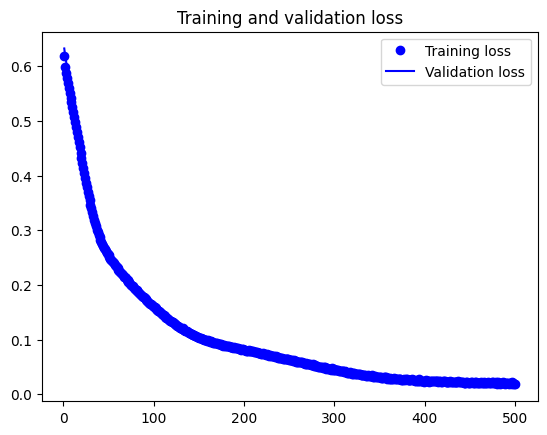

In [66]:
# Plot the training history
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

7/7 [==============================] - 0s 1ms/step


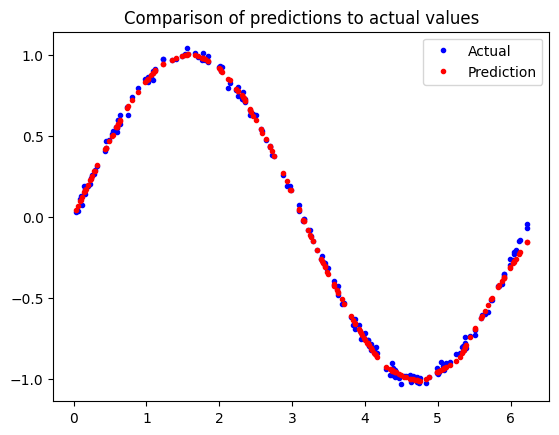

In [67]:
# Plot predictions against actual values
predictions = model.predict(x_test)

plt.clf()
plt.title("Comparison of predictions to actual values")
plt.plot(x_test, y_test, 'b.', label='Actual')
plt.plot(x_test, predictions, 'r.', label='Prediction')
plt.legend()
plt.show()

In [68]:
# Convert Keras model to a tflite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

open(tflite_model_name + '.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpplfbxhel/assets


INFO:tensorflow:Assets written to: /tmp/tmpplfbxhel/assets
2023-08-27 02:19:59.722728: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-08-27 02:19:59.722757: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-08-27 02:19:59.722962: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpplfbxhel
2023-08-27 02:19:59.723796: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-08-27 02:19:59.723814: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpplfbxhel
2023-08-27 02:19:59.727068: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-08-27 02:19:59.771421: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/tmpplfbxhel
2023-08-27 02:19:59.781391: I tensorflow/cc/saved_model/loader.cc:314] SavedModel

4032

In [69]:
print(tflite_model)

b'\x1c\x00\x00\x00TFL3\x14\x00 \x00\x1c\x00\x18\x00\x14\x00\x10\x00\x0c\x00\x00\x00\x08\x00\x04\x00\x14\x00\x00\x00\x1c\x00\x00\x00\x98\x00\x00\x00\xf0\x00\x00\x00\x8c\t\x00\x00\x9c\t\x00\x00\\\x0f\x00\x00\x03\x00\x00\x00\x01\x00\x00\x00\x10\x00\x00\x00\x00\x00\n\x00\x10\x00\x0c\x00\x08\x00\x04\x00\n\x00\x00\x00\x0c\x00\x00\x00\x1c\x00\x00\x00<\x00\x00\x00\x0f\x00\x00\x00serving_default\x00\x01\x00\x00\x00\x04\x00\x00\x00\x90\xff\xff\xff\n\x00\x00\x00\x04\x00\x00\x00\x08\x00\x00\x00dense_20\x00\x00\x00\x00\x01\x00\x00\x00\x04\x00\x00\x00\xee\xf5\xff\xff\x04\x00\x00\x00\x0e\x00\x00\x00dense_18_input\x00\x00\x02\x00\x00\x004\x00\x00\x00\x04\x00\x00\x00\xdc\xff\xff\xff\r\x00\x00\x00\x04\x00\x00\x00\x13\x00\x00\x00CONVERSION_METADATA\x00\x08\x00\x0c\x00\x08\x00\x04\x00\x08\x00\x00\x00\x0c\x00\x00\x00\x04\x00\x00\x00\x13\x00\x00\x00min_runtime_version\x00\x0e\x00\x00\x00\x98\x08\x00\x00\x90\x08\x00\x00|\x08\x00\x00\x1c\x08\x00\x00\xbc\x07\x00\x00\\\x07\x00\x00\x0c\x01\x00\x00\xac\x00\x00\x0

In [70]:
from tensorflow.lite.python.util import convert_bytes_to_c_source

source_text, header_text = convert_bytes_to_c_source(tflite_model,  "sine_model")

with  open('sine_model.h',  'w')  as  file:
    file.write(header_text)

with  open('sine_model.cc',  'w')  as  file:
    file.write(source_text)